# The Best Model for TPSAPR22 Without Neural Networks

This notebook shows how to solve TPSAPR22 with good feature engineering and a `HistGradientBoostingClassifier`. It furthermore shows how to cross-validate correctly without creating a data leak.

Some features have been inspired by C4rl05/V's [XGBoost notebook](https://www.kaggle.com/code/cv13j0/tps-apr-2022-xgboost-model).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats

from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.pipeline import make_pipeline
pd.options.display.precision = 3
# pd.set_option("precision", 3)
plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])

/opt/conda/envs/kaggle/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# Reading the data

We read the data and pivot the training data so that we have a dataframe with one row per sequence.

In [3]:
# Reading the data
train = pd.read_pickle('../dataset/pkl/train.pkl')
train_labels = pd.read_csv('../dataset/csv/train_labels.csv')
test = pd.read_pickle('../dataset/pkl/test.pkl')

sensors = [col for col in train.columns if 'sensor_' in col]

train_pivoted0 = train.pivot(index=['sequence', 'subject'], columns='step', values=sensors)
display(train_pivoted0)

sensor_00                                                   \
step                    0      1      2      3      4      5      6      7    
sequence subject                                                              
0        47         -0.196 -0.447  0.327  0.523  0.272 -1.073  0.351 -0.304   
1        66         -6.658  1.634  1.863 -2.846  0.594  2.470 -1.202 -0.829   
2        66         -1.742  3.403 -0.632  0.209 -0.801 -2.274  2.009 -0.563   
3        542         0.264 -1.808  0.079  1.037 -0.189 -1.303  1.079  2.257   
4        437         0.567 -0.824  1.477 -1.710 -0.409  0.556  0.853 -0.406   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
25963    558        -1.441  2.359 -0.882  1.299 -0.862 -1.428  0.125  2.120   
25964    297         0.997  0.416  1.874 -5.220  2.927 -0.311  0.497  0.372   
25965    129        -0.097 -0.861  0.929  0.750  1.347 -3.423  0.984  2.818   
25966    170        -0.357 -1.604 -0.297  0.274  0.462  0.245 -0.342 -0.230   
25967    327        -0.314  0.393 -0.554  0.070 -0.258  0.095  0.387 -0.825   

                                ... sensor_12                                  \
step                 8      9   ...        50      51      52      53      54   
sequence subject                ...                                             
0        47      -0.216  0.304  ...    -1.670  -5.306   3.621   4.965  -3.615   
1        66       1.091 -0.335  ...    -0.338   0.235   0.031   0.038  -0.120   
2        66      -0.050  0.801  ...    -0.173   0.092  -0.029  -0.202   0.332   
3        542     -2.284 -2.760  ...     0.145  -0.046  -0.098  -0.049   0.056   
4        437     -0.009 -0.022  ...     0.002  -0.051  -0.025   0.106  -0.098   
...                 ...    ...  ...       ...     ...     ...     ...     ...   
25963    558      0.209  1.848  ...     0.049  -0.090   0.059  -0.014  -0.084   
25964    297     -0.342 -0.566  ...    36.889  21.105  -4.421  16.872  -4.327   
25965    129     -1.461 -1.988  ...     2.395  -0.677   1.435  -0.646  -0.449   
25966    170      0.877 -1.197  ...    14.011  48.827  25.958  -7.077 -12.376   
25967    327      0.471 -0.037  ...     0.909  -0.831  -1.007   1.064   0.640   

                                                         
step                  55     56      57      58      59  
sequence subject                                         
0        47        0.791  5.887  -7.211 -26.739 -50.659  
1        66        0.057  0.062  -0.014   0.098  -0.115  
2        66       -0.013  0.246  -0.091  -0.307   0.046  
3        542      -0.022  0.054  -0.185   0.311  -0.166  
4        437      -0.040  0.136   0.122  -0.060  -0.088  
...                  ...    ...     ...     ...     ...  
25963    558       0.026  0.036  -0.042   0.029  -0.016  
25964    297     -13.625  9.957 -13.389 -17.124   9.220  
25965    129       0.272 -0.263   0.713  -1.379   1.802  
25966    170       9.170  6.790 -15.287 -10.660  19.437  
25967    327      -0.915 -0.516   0.928   0.211  -1.561  

[25968 rows x 780 columns]

# Feature engineering

Let's keep it simple and calculate only the following features:
- For every sensor, we calculate mean, standard deviation, interquartile range, standard deviation divided by mean, and kurtosis. This gives the first 5\*13=65 features.
- For the special sensor_02, we count how many times it goes up or down.
- For sensor_02, we calculate the sum of all upward / downward steps, the maximum of all upward / downward steps, and the mean of all upward / downward steps. 
- For every subject, we count how many sequences belong to it, and we add this count as a feature to all sequences of the subject (the [EDA](https://www.kaggle.com/code/ambrosm/tpsapr22-eda-which-makes-sense) gives the motivation for this feature). 

Now we have 74 features. 

In [4]:
# Feature engineering
def engineer(df):
    new_df = pd.DataFrame([], index=df.index)
    for sensor in sensors:
        new_df[sensor + '_mean'] = df[sensor].mean(axis=1)
        new_df[sensor + '_std'] = df[sensor].std(axis=1)
        new_df[sensor + '_iqr'] = scipy.stats.iqr(df[sensor], axis=1)
        new_df[sensor + '_sm'] = np.nan_to_num(new_df[sensor + '_std'] / 
                                               new_df[sensor + '_mean'].abs()).clip(-1e30, 1e30)
        new_df[sensor + '_kurtosis'] = scipy.stats.kurtosis(df[sensor], axis=1)
    new_df['sensor_02_up'] = (df.sensor_02.diff(axis=1) > 0).sum(axis=1)
    new_df['sensor_02_down'] = (df.sensor_02.diff(axis=1) < 0).sum(axis=1)
    new_df['sensor_02_upsum'] = df.sensor_02.diff(axis=1).clip(0, None).sum(axis=1)
    new_df['sensor_02_downsum'] = df.sensor_02.diff(axis=1) .clip(None, 0).sum(axis=1)
    new_df['sensor_02_upmax'] = df.sensor_02.diff(axis=1).max(axis=1)
    new_df['sensor_02_downmax'] = df.sensor_02.diff(axis=1).min(axis=1)
    new_df['sensor_02_upmean'] = np.nan_to_num(new_df['sensor_02_upsum'] / new_df['sensor_02_up'], posinf=40)
    new_df['sensor_02_downmean'] = np.nan_to_num(new_df['sensor_02_downsum'] / new_df['sensor_02_down'], neginf=-40)
    return new_df

train_pivoted = engineer(train_pivoted0)

train_shuffled = train_pivoted.sample(frac=1.0, random_state=1)
labels_shuffled = train_labels.reindex(train_shuffled.index.get_level_values('sequence'))
labels_shuffled = labels_shuffled[['state']].merge(train[['sequence', 'subject']].groupby('sequence').min(),
                                                   how='left', on='sequence')
labels_shuffled = labels_shuffled.merge(labels_shuffled.groupby('subject').size().rename('sequence_count'),
                                        how='left', on='subject')
train_shuffled['sequence_count_of_subject'] = labels_shuffled['sequence_count'].values

selected_columns = train_shuffled.columns
print(len(selected_columns))
#train_shuffled.columns

74


To get a first impression of the usefulness of the 74 features, we plot how the target depends on every feature, i.e., a diagram of $P(y=1|x)$.  To get a meaningful plot, we apply two transformations:
- The x axis is not the value of the feature, but its index (when sorted by feature value).
- The y axis is not the target value (which can be only 0 or 1), but a rolling mean over 1000 targets.

The diagram shows bad features with an almost horizontal line (the probability of the positive target is 0.5 independently of the feature value) (e.g. sensor_05_std). Good features have a curve with high y_max - y_min (e.g. sensor_02_std). 

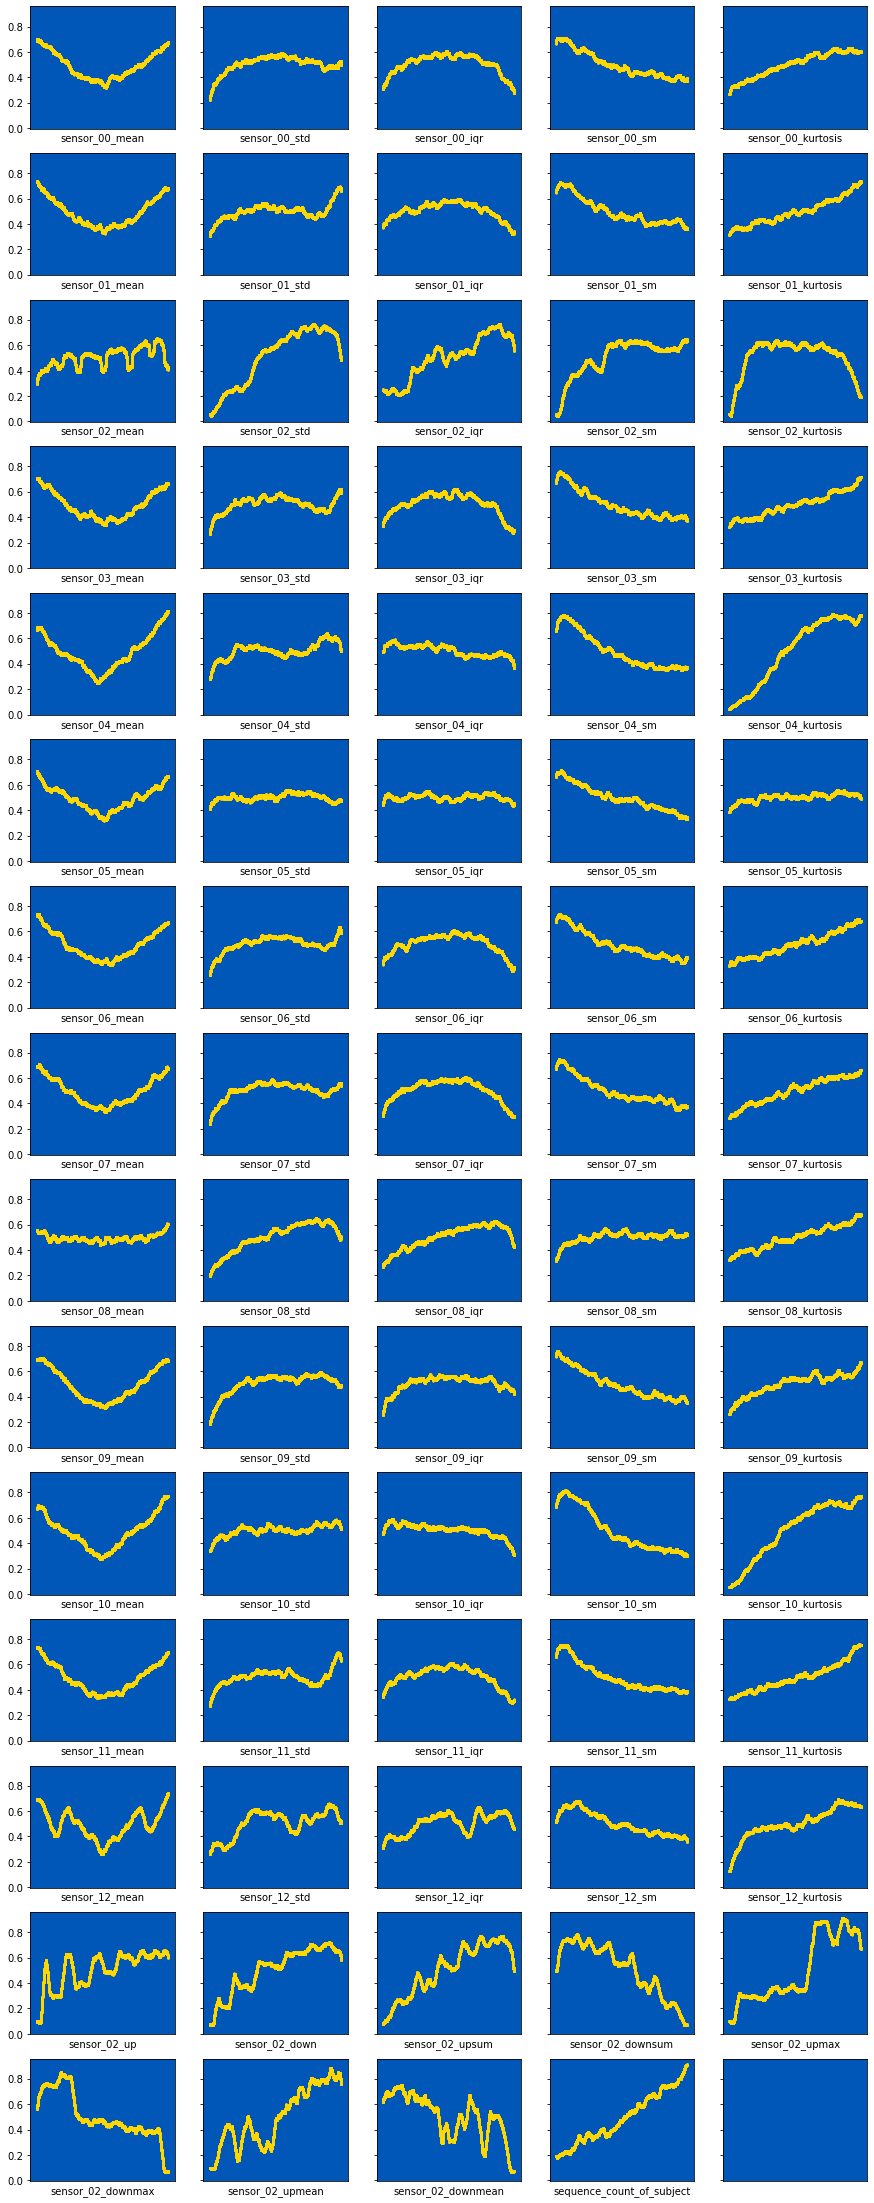

In [5]:
# Plot dependence between every feature and the target
ncols = len(train_shuffled.columns) // 13
plt.subplots(15, ncols, sharey=True, sharex=True, figsize=(15, 40))
for i, col in enumerate(train_shuffled.columns):
    temp = pd.DataFrame({col: train_shuffled[col].values,
                         'state': labels_shuffled.state.values})
    temp = temp.sort_values(col)
    temp.reset_index(inplace=True)
    plt.subplot(15, ncols, i+1)
    plt.scatter(temp.index, temp.state.rolling(1000).mean(), s=2)
    plt.xlabel(col)
    plt.xticks([])
plt.show()

# Feature selection

We don't need all 74 features. In a first step we drop 26 features which proved to be useless in a previous run of the notebook.

In [6]:
# Drop some useless features
dropped_features = ['sensor_05_kurtosis', 'sensor_08_mean',
                    'sensor_05_std', 'sensor_06_kurtosis',
                    'sensor_06_std', 'sensor_03_std',
                    'sensor_02_kurtosis', 'sensor_03_kurtosis',
                    'sensor_09_kurtosis', 'sensor_03_mean',
                    'sensor_00_mean', 'sensor_02_iqr',
                    'sensor_05_mean', 'sensor_06_mean',
                    'sensor_07_std', 'sensor_10_iqr',
                    'sensor_11_iqr', 'sensor_12_iqr',
                    'sensor_09_mean', 'sensor_02_sm',
                    'sensor_03_sm', 'sensor_05_iqr', 
                    'sensor_06_sm', 'sensor_09_iqr', 
                    'sensor_07_iqr', 'sensor_10_mean']
selected_columns = [f for f in selected_columns if f not in dropped_features]
len(selected_columns)

48

Now we select features sequentially. We start with zero features and add one feature after the other. In every step we select the feature which increases the model's validation score the most. In this example, we select all features, and the output tells us which features are useful and which aren't.

The same algorithm can be run backward by setting `backward` to `True`. It then starts with all features and repeatedly deletes the feature which adds the least value to the model's validation score.

The model is a `HistGradientBoostingClassifier`.

Added feature: sensor_04_kurtosis             0.787
Added feature: sensor_02_upmax                0.861
Added feature: sequence_count_of_subject      0.899
Added feature: sensor_02_downmax              0.918
Added feature: sensor_02_std                  0.923
Added feature: sensor_10_sm                   0.927
Added feature: sensor_00_std                  0.929
Added feature: sensor_05_sm                   0.931
Added feature: sensor_11_sm                   0.933
Added feature: sensor_10_kurtosis             0.934
Added feature: sensor_02_downsum              0.936
Added feature: sensor_12_sm                   0.937
Added feature: sensor_12_std                  0.938
Added feature: sensor_04_iqr                  0.938
Added feature: sensor_04_mean                 0.939
Added feature: sensor_00_kurtosis             0.940
Added feature: sensor_08_std                  0.941
Added feature: sensor_02_upmean               0.941
Added feature: sensor_09_sm                   0.942
Added featur

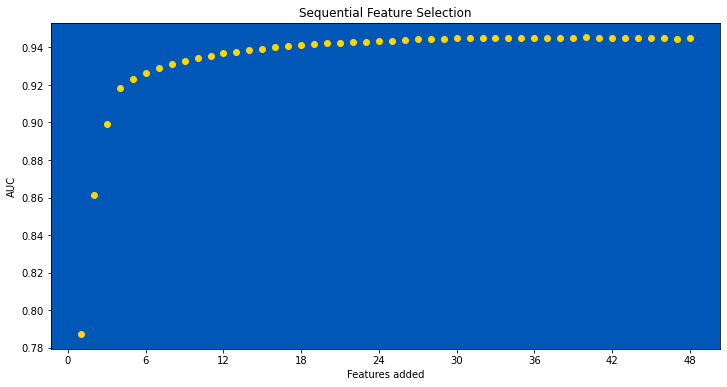

['sensor_00_std' 'sensor_00_iqr' 'sensor_00_sm' 'sensor_00_kurtosis'
 'sensor_01_mean' 'sensor_01_std' 'sensor_01_iqr' 'sensor_01_sm'
 'sensor_01_kurtosis' 'sensor_02_mean' 'sensor_02_std' 'sensor_03_iqr'
 'sensor_04_mean' 'sensor_04_std' 'sensor_04_iqr' 'sensor_04_sm'
 'sensor_04_kurtosis' 'sensor_05_sm' 'sensor_06_iqr' 'sensor_07_mean'
 'sensor_07_sm' 'sensor_07_kurtosis' 'sensor_08_std' 'sensor_08_iqr'
 'sensor_08_sm' 'sensor_08_kurtosis' 'sensor_09_std' 'sensor_09_sm'
 'sensor_10_std' 'sensor_10_sm' 'sensor_10_kurtosis' 'sensor_11_mean'
 'sensor_11_std' 'sensor_11_sm' 'sensor_11_kurtosis' 'sensor_12_mean'
 'sensor_12_std' 'sensor_12_sm' 'sensor_12_kurtosis' 'sensor_02_up'
 'sensor_02_down' 'sensor_02_upsum' 'sensor_02_downsum' 'sensor_02_upmax'
 'sensor_02_downmax' 'sensor_02_upmean' 'sensor_02_downmean'
 'sequence_count_of_subject']


In [32]:
# Sequential feature selection
# This code is a more verbose form of scikit-learn's SequentialFeatureSelector
estimator = HistGradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=25,
                                       max_iter=1000, min_samples_leaf=500,
                                       l2_regularization=1,
                                       max_bins=255,
                                       random_state=4, verbose=0)

X, y = train_shuffled[selected_columns], labels_shuffled.state
n_iterations, backward = 48, False

if n_iterations != 0:
    n_features = X.shape[1]
    current_mask = np.zeros(shape=n_features, dtype=bool)
    history = []
    for _ in range(n_iterations):
        candidate_feature_indices = np.flatnonzero(~current_mask)
        scores = {}
        for feature_idx in candidate_feature_indices:
            candidate_mask = current_mask.copy()
            candidate_mask[feature_idx] = True
            X_new = X.values[:, ~candidate_mask if backward else candidate_mask]
            scores[feature_idx] = cross_val_score(
                estimator,
                X_new,
                y,
                cv=GroupKFold(n_splits=5),
                groups=train_shuffled.index.get_level_values('subject'),
                scoring='roc_auc',
                n_jobs=-1,
            ).mean()
            #print(f"{str(X.columns[feature_idx]):30} {scores[feature_idx]:.3f}")
        new_feature_idx = max(scores, key=lambda feature_idx: scores[feature_idx])
        current_mask[new_feature_idx] = True
        history.append(scores[new_feature_idx])
        new = 'Deleted' if backward else 'Added'
        print(f'{new} feature: {str(X.columns[new_feature_idx]):30}'
              f' {scores[new_feature_idx]:.3f}')

    print()
    plt.figure(figsize=(12, 6))
    plt.scatter(np.arange(len(history)) + (0 if backward else 1), history)
    plt.ylabel('AUC')
    plt.xlabel('Features removed' if backward else 'Features added')
    plt.title('Sequential Feature Selection')
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

    if backward:
        current_mask = ~current_mask
    selected_columns = np.array(selected_columns)[current_mask]
    print(selected_columns)


# Cross-validation

For cross-validation, we use a GroupKFold grouped on subjects. If we didn't group on subjects, we'd have a data leak (see the [EDA](https://www.kaggle.com/code/ambrosm/tpsapr22-eda-which-makes-sense) for an explanation).

The model is a `HistGradientBoostingClassifier`; I got the same cv score using an `XGBClassifier`.

In [10]:
%%time
# Cross-validation of the classifier

print(f"{len(selected_columns)} features")
score_list = []
kf = GroupKFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train_shuffled, groups=train_shuffled.index.get_level_values('subject'))):
    X_tr = train_shuffled.iloc[idx_tr][selected_columns]
    X_va = train_shuffled.iloc[idx_va][selected_columns]
    y_tr = labels_shuffled.iloc[idx_tr].state
    y_va = labels_shuffled.iloc[idx_va].state

    model = HistGradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=25,
                                           max_iter=1000, min_samples_leaf=500,
                                           l2_regularization=1,
                                           validation_fraction=0.05,
                                           max_bins=63,
                                           random_state=3, verbose=0)
#     model = XGBClassifier(n_estimators=500, n_jobs=-1,
#                           eval_metric=['logloss'],
#                           #max_depth=10,
#                           colsample_bytree=0.8,
#                           #gamma=1.4,
#                           reg_alpha=6, reg_lambda=1.5,
#                           tree_method='hist',
#                           learning_rate=0.03,
#                           verbosity=1,
#                           use_label_encoder=False, random_state=3)

    if True or type(model) != XGBClassifier:
        model.fit(X_tr.values, y_tr)
    else:
        model.fit(X_tr.values, y_tr, eval_set = [(X_va.values, y_va)], 
                  eval_metric = ['auc'], early_stopping_rounds=30, verbose=10)
    try:
        y_va_pred = model.decision_function(X_va.values) # HistGradientBoostingClassifier
    except AttributeError:
        try:
            y_va_pred = model.predict_proba(X_va.values)[:,1] # XGBClassifier
        except AttributeError:
            y_va_pred = model.predict(X_va.values) # XGBRegressor
    score = roc_auc_score(y_va, y_va_pred)
    try:
        print(f"Fold {fold}: n_iter ={model.n_iter_:5d}    AUC = {score:.3f}")
    except AttributeError:
        print(f"Fold {fold}:                  AUC = {score:.3f}")
    score_list.append(score)
    
print(f"OOF AUC:                       {np.mean(score_list):.3f}") # 0.944


48 features
Fold 0: n_iter =  213    AUC = 0.942
Fold 1: n_iter =  280    AUC = 0.943
Fold 2: n_iter =  321    AUC = 0.949
Fold 3: n_iter =  292    AUC = 0.946
Fold 4: n_iter =  406    AUC = 0.944
OOF AUC:                       0.945
CPU times: user 3h 9min 24s, sys: 7min 42s, total: 3h 17min 6s
Wall time: 52.2 s


# ROC curve

We plot the ROC curve just because it looks nice. The area under the red curve is the score of our model.

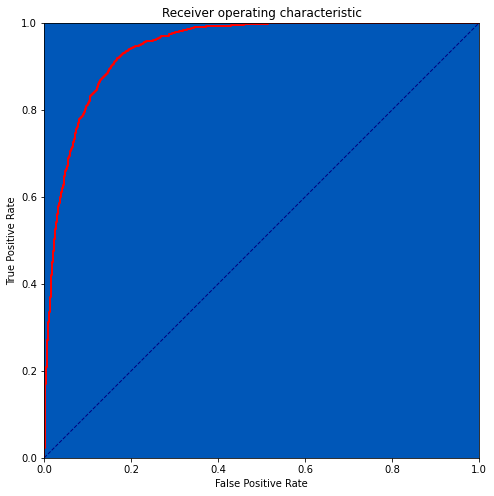

In [11]:
# Plot the roc curve for the last fold
def plot_roc_curve(y_va, y_va_pred):
    plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y_va, y_va_pred)
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.gca().set_aspect('equal')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.show()

plot_roc_curve(y_va, y_va_pred)

# Test predictions and submission

We create a submission file as follows:
1. We apply the same feature engineering to the test data as we did for the training data. Here it is important not to shuffle the test data so that the submission file is ordered correctly.
2. We retrain the `HistGradientBoostingClassifier` 100 times with different seeds on 95 % of the training data.
3. The decision functions of the 100 models can have different scales. To counter this, we convert the predictions to ranks using `scipy.stats.rankdata` and then submit the mean of the 100 ranks.

In [12]:
# Feature engineering for test
test_pivoted0 = test.pivot(index=['sequence', 'subject'], columns='step', values=sensors)
test_pivoted = engineer(test_pivoted0)
sequence_count = test_pivoted.index.to_frame(index=False).groupby('subject').size().rename('sequence_count_of_subject')
#display(test_pivoted.head(2))
submission = pd.DataFrame({'sequence': test_pivoted.index.get_level_values('sequence')})
test_pivoted = test_pivoted.merge(sequence_count, how='left', on='subject')
test_pivoted.head(2)

,sensor_00_mean,sensor_00_std,sensor_00_iqr,sensor_00_sm,sensor_00_kurtosis,sensor_01_mean,sensor_01_std,sensor_01_iqr,sensor_01_sm,sensor_01_kurtosis,...,sensor_12_kurtosis,sensor_02_up,sensor_02_down,sensor_02_upsum,sensor_02_downsum,sensor_02_upmax,sensor_02_downmax,sensor_02_upmean,sensor_02_downmean,sequence_count_of_subject
subject,,,,,,,,,,,,,,,,,,,,,
684,-0.003,1.092,1.079,419.618,6.401,-0.036,4.499,0.99,123.503,13.679,...,-0.294,4,8,0.667,-1.333,0.177,-0.177,0.167,-0.167,70
935,0.029,1.450,0.844,50.850,6.634,0.002,0.775,1.08,340.690,0.125,...,-1.045,5,9,1.227,-1.560,0.560,-0.229,0.245,-0.173,59


In [13]:
# Retrain, predict and write submission
print(f"{len(selected_columns)} features")

pred_list = []
for seed in range(100):
    X_tr = train_shuffled[selected_columns]
    y_tr = labels_shuffled.state

    model = HistGradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=25,
                                           max_iter=1000, min_samples_leaf=500,
                                           validation_fraction=0.05,
                                           l2_regularization=1,
                                           max_bins=63,
                                           random_state=seed, verbose=0)
    model.fit(X_tr.values, y_tr)
    pred_list.append(scipy.stats.rankdata(model.decision_function(test_pivoted[selected_columns].values)))
    print(f"{seed:2}", pred_list[-1])
print()
submission['state'] = sum(pred_list) / len(pred_list)
submission.to_csv('submission.csv', index=False)
submission

48 features
 0 [ 8571. 11650.   412. ...  5840.   955.  2553.]
 1 [ 8823. 11782.   999. ...  6063.   797.  2893.]
 2 [ 9157. 11859.   756. ...  5886.  1251.  2681.]
 3 [ 8049. 11549.   633. ...  6104.   843.  2819.]
 4 [ 8407. 11819.   817. ...  5804.  1467.  2968.]
 5 [ 8296. 11717.   768. ...  5953.  1283.  2943.]
 6 [ 8401. 11796.   676. ...  5780.  1258.  3048.]
 7 [ 8132. 11701.   827. ...  6391.  1181.  2453.]
 8 [ 8291. 11642.   730. ...  5783.  1106.  2940.]
 9 [ 8274. 11824.   747. ...  5833.  1185.  2803.]
10 [ 8225. 11618.   699. ...  5901.  1062.  2557.]
11 [ 9055. 11444.   907. ...  5744.  1244.  3306.]
12 [ 8549. 11985.   394. ...  6428.   885.  2984.]
13 [ 8399. 11830.   770. ...  5360.  1059.  2827.]
14 [ 8162. 11682.   811. ...  6170.   970.  3378.]
15 [ 7993. 11607.  1002. ...  6005.   812.  2678.]
16 [ 8899. 11613.   667. ...  6682.  1078.  2362.]
17 [ 8383. 11962.   500. ...  5783.  1298.  2678.]
18 [ 8060. 11824.   543. ...  6418.  1018.  2791.]
19 [ 8503. 11934.  

KeyboardInterrupt: 